from sklearnex import patch_sklearn
patch_sklearn()

# IO

In [1]:
from PineBioML import IO

In [2]:
# Path
input_folder = "./input/"
output_folder = "./output/"
export_title = "example_basic "

In [3]:
x, y = IO.read_multiple_groups(
    file_path_list=[
        input_folder+ "example_group1.csv", # all samples from this file will have y = 0, because it is in the 1st place of the file path list.
        input_folder+ "example_group2.tsv", # all samples from this file will have y = 1, because it is in the 2nd place of the file path list.
    ],
    index_col=0
    )

In [4]:
y.describe()

count    200.000000
mean       0.500000
std        0.501255
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
dtype: float64

In [5]:
target_label = 1.0

# Train test split

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33, random_state=142, shuffle=True, stratify=y)

# Experiment

In [ ]:
from PineBioML.model.utils import Pine, sklearn_esitimator_wrapper

from PineBioML.preprocessing import Normalizer, Pass
from PineBioML.preprocessing.impute import knn_imputer, simple_imputer
from PineBioML.preprocessing.utils import feature_extension
from PineBioML.selection.classification import ensemble_selector
from PineBioML.model.supervised import Classification
from sklearn.linear_model import LogisticRegression


# define the experiment pipeline
experiment = [
    ("MissingValueProcessing", {
        "mean": simple_imputer(threshold=1., strategy="mean")
    }),
    ("Standarization", {
        "StandardScaler": Normalizer(method="StandardScaler"),
    }),
    ("Selection", {
        "ensemble": ensemble_selector(RF_trees=256, z_importance_threshold=1),
        "None": Pass()
    }),
    ("Modeling", {
        "LgisticRegression":
        sklearn_esitimator_wrapper(LogisticRegression(penalty=None)),
        "ElasticLogisticRegression":
        Classification.ElasticLogit_tuner(target="auc"),
        "rbf-SVM":
        Classification.SVM_tuner(target="acc"),
        "DecistionTree":
        Classification.DecisionTree_tuner(target="auc"),
        "RandomForest":
        Classification.RandomForest_tuner(target="auc"),
        "AdaBoost":
        Classification.AdaBoost_tuner(target="auc"),
        "XGBoost":
        Classification.XGBoost_tuner(target="auc"),
        "LightGBM":
        Classification.LightGBM_tuner(target="auc"),
    }),
]

In [8]:
pine_automl = Pine(experiment, target_label = target_label, cv_result= True, evaluate_ncv = 3)
result = pine_automl.do_experiment(x_train, y_train, x_valid, y_valid)

Using  c45  to select.


100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


c45  is done. Using 3.6913

Using  RF_gini  to select.
RF_gini  is done. Using 0.1866

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done. Using 0.0354

Using  multi_Lasso  to select.
multi_Lasso  is done. Using 0.1358

Using  SVM  to select.
SVM  is done. Using 0.0160

optuna seed 13234  |  validation seed 5091  |  model seed 7591
    RandomForest start tuning. it will take a while.
    default is better.
optuna seed 13993  |  validation seed 2998  |  model seed 12133
    XGBoost start tuning. it will take a while.
    optuna is better, best trial:  3
optuna seed 5100  |  validation seed 10607  |  model seed 14270
    LightGBM start tuning. it will take a while.
    optuna is better, best trial:  70
optuna seed 5253  |  validation seed 3720  |  model seed 5422
    rbf-SVM start tuning. it will take a while.
    optuna is better, best trial:  11
optuna seed 1069  |  validation seed 13990  |  model seed 1884
    ElasticNetLogisticRegression start tuning. it will take a while.
 

c:\Users\aimhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aimhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


optuna seed 13234  |  validation seed 5091  |  model seed 7591
    RandomForest start tuning. it will take a while.
    default is better.
optuna seed 13993  |  validation seed 2998  |  model seed 12133
    XGBoost start tuning. it will take a while.
    optuna is better, best trial:  7
optuna seed 5100  |  validation seed 10607  |  model seed 14270
    LightGBM start tuning. it will take a while.
    optuna is better, best trial:  24
optuna seed 5253  |  validation seed 3720  |  model seed 5422
    rbf-SVM start tuning. it will take a while.
    optuna is better, best trial:  8
optuna seed 1069  |  validation seed 13990  |  model seed 1884
    ElasticNetLogisticRegression start tuning. it will take a while.
    optuna is better, best trial:  12
optuna seed 1253  |  validation seed 3566  |  model seed 4659
    AdaBoost start tuning. it will take a while.
    optuna is better, best trial:  16
optuna seed 4938  |  validation seed 1006  |  model seed 4286
    DecisionTree start tuning. it

c:\Users\aimhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aimhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
pine_automl.experiment_detail()

,parameter,dtype,lower_bound,upper_bound,result
RandomForest,None,None,None,None,None
,n_estimators,int,32,1024,100.0
,min_samples_leaf,int,1,32,1.0
,ccp_alpha,float,0.000001,0.1,0.0
,max_samples,float,0.4,0.8,NaN
XGBoost,None,None,None,None,None
,n_estimators,int,4,256,6.0
,max_depth,int,3,14,9.0
,gamma,float,0.001,0.1,0.083383
,learning_rate,float,0.01,1.0,0.281846


In [10]:
# print the results, sort according to test_auc
result.sort_values("test_auc")

,MissingValueProcessing,Standarization,Selection,Modeling,train_sensitivity,train_f1,train_specificity,train_auc,train_mcc,train_accuracy,...,cv_mcc,cv_accuracy,cv_support,test_sensitivity,test_f1,test_specificity,test_auc,test_mcc,test_accuracy,test_support
9,mean,StandardScaler,None,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.259494,0.619658,26.8,0.545455,0.537313,0.515152,0.580808,0.060634,0.530303,66
8,mean,StandardScaler,None,LgisticRegression,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.255169,0.619943,26.8,0.666667,0.602740,0.454545,0.605601,0.124035,0.560606,66
12,mean,StandardScaler,None,rbf-SVM,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.321531,0.649858,26.8,0.696970,0.630137,0.484848,0.615243,0.186052,0.590909,66
11,mean,StandardScaler,None,LightGBM,0.940299,0.900000,0.850746,0.966808,0.794236,0.895522,...,0.313425,0.648718,26.8,0.696970,0.630137,0.484848,0.617998,0.186052,0.590909,66
10,mean,StandardScaler,None,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.267494,0.627350,26.8,0.606061,0.588235,0.545455,0.625344,0.151794,0.575758,66
15,mean,StandardScaler,None,DecistionTree,0.000000,0.000000,1.000000,0.980953,0.000000,0.500000,...,0.295267,0.642165,26.8,0.000000,0.000000,1.000000,0.626722,0.000000,0.500000,66
7,mean,StandardScaler,ensemble,DecistionTree,0.000000,0.000000,1.000000,0.870016,0.000000,0.500000,...,0.358375,0.671510,26.8,0.000000,0.000000,1.000000,0.629477,0.000000,0.500000,66
13,mean,StandardScaler,None,ElasticLogisticRegression,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.315021,0.649288,26.8,0.818182,0.675000,0.393939,0.647383,0.234246,0.606061,66
2,mean,StandardScaler,ensemble,XGBoost,1.000000,0.985294,0.970149,0.999332,0.970582,0.985075,...,0.383956,0.686325,26.8,0.636364,0.626866,0.606061,0.651056,0.242536,0.621212,66
3,mean,StandardScaler,ensemble,LightGBM,0.791045,0.821705,0.865672,0.928603,0.658553,0.828358,...,0.406562,0.700570,26.8,0.666667,0.656716,0.636364,0.683655,0.303170,0.651515,66


In [11]:
# save the result
result.to_csv("./output/example_Pine_result.csv")

# Pick a model and save it

In [18]:
# notice that the model is not fitted yet
model = pine_automl.recall_model(id = 5)

In [19]:
# fit the model
model.fit(x_train, y_train)
y_valid_prob = model.predict_proba(x_valid)

Using  c45  to select.


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1227.89it/s]


c45  is done. Using 0.2139

Using  RF_gini  to select.
RF_gini  is done. Using 0.1807

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done. Using 0.0284

Using  multi_Lasso  to select.
multi_Lasso  is done. Using 0.1440

Using  SVM  to select.
SVM  is done. Using 0.0113

optuna seed 1069  |  validation seed 13990  |  model seed 1884
    ElasticNetLogisticRegression start tuning. it will take a while.
    optuna is better, best trial:  11


c:\Users\aimhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


### summary

             precision    recall  f1-score support
0.0           0.657895  0.757576  0.704225    33.0
1.0           0.714286  0.606061  0.655738    33.0
                                                  
macro avg      0.68609  0.681818  0.679982    66.0
weighted avg   0.68609  0.681818  0.679982    66.0
accuracy                          0.681818    66.0
sensitivity                       0.606061    33.0
specificity                       0.757576    33.0


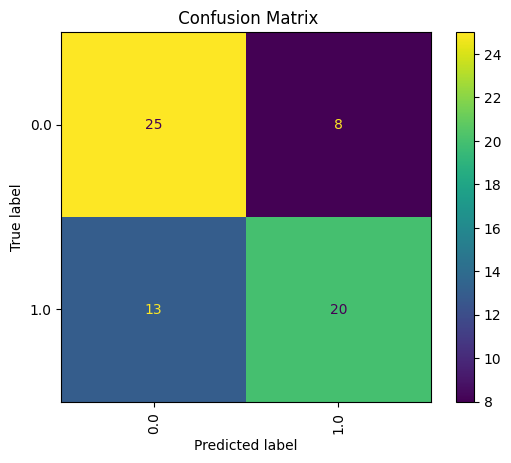

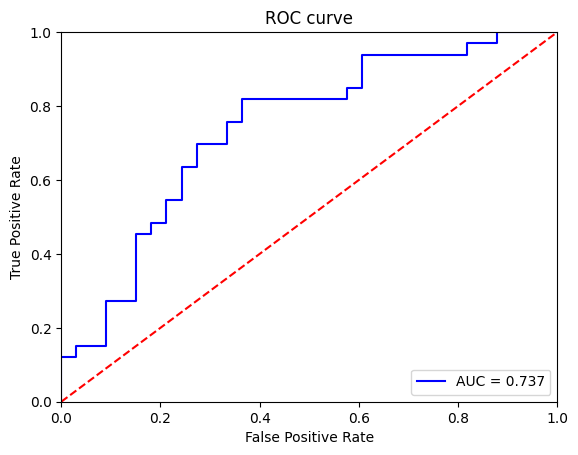

In [20]:
from PineBioML.report.utils import classification_summary

classification_summary(y_valid, y_valid_prob, target_label=target_label, save_fig=True, save_path="./output/images")

### save the model

IO.save_model(model, "./output/models/", "mode0", overide=True)